<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# The Linear Diffusion Overland Flow Route

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

## Overview

This notebook demonstrates the `LinearDiffusionOverlandFlowRouter` Landlab component. The component implements a two-dimensional model of overland flow, based on a linearization of the diffusion-wave approximation of the shallow-water equations.

### Theory

#### Flow direction, depth, and velocity

The diffusion-wave equations are a simplified form of the 2D shallow-water equations in which energy slope is assumed to equal water-surface slope. Conservation of water mass is expressed in terms of the time derivative of the local water depth, $H$, and the spatial derivative (divergence) of the unit discharge vector $\mathbf{q} = UH$ (where $U$ is the 2D depth-averaged velocity vector):

$$\frac{\partial H}{\partial t} = R - \nabla\cdot \mathbf{q}$$

where $R$ is the local runoff rate [L/T] and $\mathbf{q}$ has dimensions of volume flow per time per width [L$^2$/T]. The flow velocity is calculated using a linearized form of the Manning friction law:

$$\mathbf{U} = \frac{H^{4/3}}{n^2 u_c} \nabla w$$

$$w = \eta + H$$

Here $\eta(x,y,t)$ is ground-surface elevation, $w(x,y,t)$ is water-surface elevation, $n$ is the Manning friction coefficient, and $u_c$ is a characteristic scale velocity (see, e.g., Mariotti, 2018). Thus, there are two parameters governing flow speed: $n$ and $u_c$. The may, however, be treated as a single lumped parameter $n^2 u_c$.

#### Rainfall and infiltration

Runoff rate is calculated as the difference between the rates of precipitation, $P$, and infiltration, $I$. The user specifies a precipitation rate (which is a public variable that can be modified after instantiation), and a maximum infiltration rate, $I_c$. The actual infiltration rate depends on the available surface water, and is calculated in a way that allows it to approach zero as the surface-water depth approaches zero:

$$I = I_c \left( 1 - e^{-H/H_i} \right)$$

where $H_i$ is a characteristic water depth, defined such that the actual infiltration rate is about 95% of $I_c$ when $H = 3 H_i$.


### The component

Import the needed libraries, then inspect the component's docstring:

In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components.overland_flow import LinearDiffusionOverlandFlowRouter
from landlab.io.esri_ascii import read_esri_ascii

In [2]:
print(LinearDiffusionOverlandFlowRouter.__doc__)

Calculate water flow over topography.

    Landlab component that implements a two-dimensional, linearized
    diffusion-wave model. The diffusion-wave approximation is a simplification
    of the shallow-water equations that omits the momentum terms. The flow
    velocity is calculated using the local water-surface slope as an
    approximation of the energy slope. With this linearized form, flow velocity
    is calculated using a linearized Manning equation, with the water-surface
    slope being used as the slope factor. There are two governing equations, one
    that represents conservation of water mass:

    ..math::

        \frac{\partial H}{\partial t} = (P - I) - \nabla\cdot\mathbf{q}

    where :math:`H(x,y,t)` is local water depth, :math:`t` is time, :math:`P`
    is precipitation rate, :math:`I` is infiltration rate, and :math:`\mathbf{q}`
    is specific water discharge, which equals depth times depth-averaged
    velocity. The other governing equation represents specific

The docstring for the `__init__` method will give us a list of parameters:

In [3]:
print(LinearDiffusionOverlandFlowRouter.__init__.__doc__)

Initialize the LinearDiffusionOverlandFlowRouter.

        Parameters
        ----------
        grid : ModelGrid
            Landlab ModelGrid object
        roughness : float, defaults to 0.01
            Manning roughness coefficient, s/m^1/3
        rain_rate : float, optional (defaults to 36 mm/hr)
            Rainfall rate, m/s
        infilt_depth_scale : float, defaults to 0.001
            Depth scale for water infiltration, m
        infilt_rate : float, optional (defaults to 0)
            Maximum rate of infiltration, m/s
        velocity_scale : float, defaults to 1
            Characteristic flow velocity, m/s
        


## Example 1: downpour on a single cell

The first example tests that the component can reproduce the expected steady flow depth for rain on a single cell. The input water flow rate, in m3/s, is:

$$Q_\text{in} = P \Delta x^2$$

The output flow rate is

$$Q_\text{out} = \frac{\Delta x}{n^2 u_c} H^{7/3} S_w$$

where $S_w$ is the water surface slope. We can write the water-surface slope in terms of the water height of the (one) core node (which just equals $H$, because the ground elevation is zero) and the water height at the adjacent open-boundary node, which is zero, so

$$S_w = \frac{H}{\Delta x}$$

We can therefore plug this into the equation for $Q_\text{out}$ and solve for the expected equilibrium depth:

$$H = \left(\Delta x^2 P n^2 u_c \right)^{3/10}$$

Pick the initial and run conditions

In [4]:
# Process parameters
n = 0.01  # roughness coefficient, (s/m^(1/3))
vel_scale = 1.0  # velocity scale, m/s
R = 72.0 / (3600.0 * 1000.0)  # runoff rate, m/s

# Run-control parameters
run_time = 360.0  # duration of run, (s)
nrows = 3  # number of node rows
ncols = 3  # number of node columns
dx = 2.0  # node spacing, m
dt = 2.0  # time-step size, s
plot_every = 60.0  # plot interval, s

# Derived parameters
num_steps = int(run_time / dt)

Create grid and fields:


In [5]:
# create and set up grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(False, True, True, True)  # open only on east

# add required field
elev = grid.add_zeros("topographic__elevation", at="node")

In [6]:
# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R, roughness=n, velocity_scale=vel_scale
)

In [7]:
# Helpful function to plot the profile
def plot_flow_profile(grid, olflow):
    """Plot the middle row of topography and water surface
    for the overland flow model olflow."""
    nc = grid.number_of_node_columns
    nr = grid.number_of_node_rows
    startnode = nc * (nr // 2) + 1
    midrow = np.arange(startnode, startnode + nc - 1, dtype=int)
    topo = grid.at_node["topographic__elevation"]
    plt.plot(
        grid.x_of_node[midrow],
        topo[midrow] + grid.at_node["surface_water__depth"][midrow],
        "b",
    )
    plt.plot(grid.x_of_node[midrow], topo[midrow], "k")
    plt.xlabel("Distance (m)")
    plt.ylabel("Ground and water surface height (m)")

Run the component forward in time, plotting the output in the form of a profile:

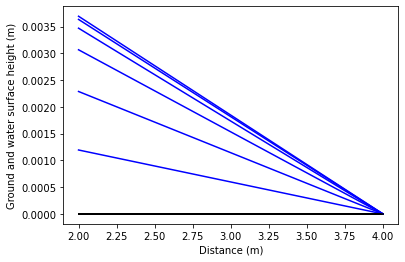

In [8]:
next_plot = plot_every
HH = []  # keep track of depth through time
for i in range(num_steps):
    olflow.run_one_step(dt)
    if (i + 1) * dt >= next_plot:
        plot_flow_profile(grid, olflow)
        next_plot += plot_every
    HH.append(grid.at_node['surface_water__depth'][4])

In [9]:
# Compare with analytical solution for depth
Rexpected = (dx * dx * R * n * n * vel_scale) ** 0.3
print('Expected depth =', Rexpected, 'm')
print('Computed depth =', grid.at_node['surface_water__depth'][4], 'm')

Expected depth = 0.0037232911332721395 m
Computed depth = 0.00369261742221 m


Text(0, 0.5, 'Water depth (m)')

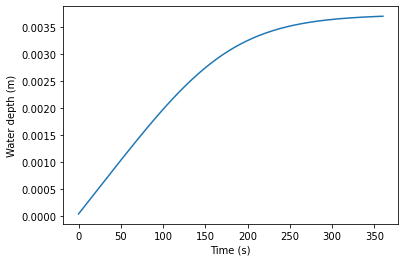

In [10]:
plt.plot(np.linspace(0, run_time, len(HH)), HH)
plt.xlabel('Time (s)')
plt.ylabel('Water depth (m)')

In [12]:
print(grid.at_link['water__velocity'])
print(olflow._depth_at_link)
grid.active_links

[-0.        -0.        -0.        -0.        -0.        -0.
  0.0105303 -0.        -0.        -0.        -0.        -0.       ]
[ 0.          0.          0.          0.00369149  0.          0.00369149
  0.00369149  0.          0.00369149  0.          0.          0.        ]


array([6])

## Example 2: overland flow on a DEM

For this example, we'll import a small digital elevation model (DEM) for a site in New Mexico, USA.

In [ ]:
# Process parameters
n = 0.1  # roughness coefficient, (s/m^(1/3))
dep_exp = 5.0 / 3.0  # depth exponent
R = 72.0  # runoff rate, mm/hr

# Run-control parameters
rain_duration = 240.0  # duration of rainfall, s
run_time = 480.0  # duration of run, s
dt = 10.0  # time-step size, s
dem_filename = "../hugo_site_filled.asc"

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge and time
time_since_storm_start = np.arange(0.0, dt * (2 * num_steps + 1), dt)
discharge = np.zeros(2 * num_steps + 1)

In [ ]:
# Read the DEM file as a grid with a 'topographic__elevation' field
(grid, elev) = read_esri_ascii(dem_filename, name="topographic__elevation")

# Configure the boundaries: valid right-edge nodes will be open;
# all NODATA (= -9999) nodes will be closed.
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(elev, -9999.0)] = grid.BC_NODE_IS_CLOSED

In [ ]:
# display the topography
cmap = copy.copy(mpl.cm.get_cmap("pink"))
imshow_grid(grid, elev, colorbar_label="Elevation (m)", cmap=cmap)

It would be nice to track discharge at the watershed outlet, but how do we find the outlet location? We actually have several valid nodes along the right-hand edge. Then we'll keep track of the field `surface_water_inflow__discharge` at these nodes. We can identify the nodes by the fact that they are (a) at the right-hand edge of the grid, and (b) have positive elevations (the ones with -9999 are outside of the watershed).

In [ ]:
indices = np.where(elev[grid.nodes_at_right_edge] > 0.0)[0]
outlet_nodes = grid.nodes_at_right_edge[indices]
print("Outlet nodes:")
print(outlet_nodes)
print("Elevations of the outlet nodes:")
print(elev[outlet_nodes])

In [ ]:
# Instantiate the component
olflow = KinwaveImplicitOverlandFlow(
    grid, runoff_rate=R, roughness=n, depth_exp=dep_exp
)

In [ ]:
discharge_field = grid.at_node["surface_water_inflow__discharge"]

for i in range(num_steps):
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(discharge_field[outlet_nodes])

In [ ]:
plt.plot(time_since_storm_start[:num_steps], discharge[:num_steps])
plt.xlabel("Time (s)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

In [ ]:
cmap = copy.copy(mpl.cm.get_cmap("Blues"))
imshow_grid(
    grid,
    grid.at_node["surface_water__depth"],
    cmap=cmap,
    colorbar_label="Water depth (m)",
)

Now turn down the rain and run it a bit longer...

In [ ]:
olflow.runoff_rate = 1.0  # just 1 mm/hr

for i in range(num_steps, 2 * num_steps):
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(discharge_field[outlet_nodes])

In [ ]:
plt.plot(time_since_storm_start, discharge)
plt.xlabel("Time (s)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

In [ ]:
cmap = copy.copy(mpl.cm.get_cmap("Blues"))
imshow_grid(
    grid,
    grid.at_node["surface_water__depth"],
    cmap=cmap,
    colorbar_label="Water depth (m)",
)

Voila! A fine hydrograph, and a water-depth map that shows deeper water in the channels (and highlights depressions in the topography).

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>